## ANWB dataset pre-processing phase

In [2]:
# Import necessary packages
from sqlalchemy import create_engine, text, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sqlite3

### Connecting to the data lake

In [3]:
# Database parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group18',
    'password': 'blockd_2024group18_44'
}

In [4]:
# Create the connection string
conn_string = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"

# Create SQLAlchemy engine
engine = create_engine(conn_string)

### Basic preprocessing techniques

In [5]:
# Convert the fetched data into a dataframe

# Query the data
query = '''SELECT * FROM data_lake.safe_driving'''

# Execute the query and fetch the data
with engine.connect() as connection:
    result = connection.execute(text(query))
    data = result.fetchall()

# Define column names
columns = ['eventid', 'event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'category', 'incident_severity', 'is_valid', 'road_segment_id', 'road_manager_type', 'road_number', 'road_name', 'place_name', 'municipality_name', 'road_manager_name']

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert 'event_start' column to datetime format and use it as an index
df['date'] = pd.to_datetime(df['event_start']).dt.date
df.set_index('date', inplace=True)

# Display the DataFrame
print(df)

             eventid             event_start               event_end  \
date                                                                   
2018-08-15  14451076 2018-08-15 16:26:18.500 2018-08-15 16:26:28.500   
2018-08-15  14319640 2018-08-15 09:47:55.500 2018-08-15 09:48:14.500   
2018-08-15  13641902 2018-08-15 04:01:26.500 2018-08-15 04:01:34.500   
2018-08-15  13473934 2018-08-15 07:22:12.600 2018-08-15 07:22:14.400   
2018-08-15  14328081 2018-08-15 10:01:42.900 2018-08-15 10:01:44.000   
...              ...                     ...                     ...   
2018-08-15  13840366 2018-08-15 10:45:57.200 2018-08-15 10:45:58.500   
2018-08-15  13788563 2018-08-15 15:34:01.800 2018-08-15 15:34:02.900   
2018-08-15  13352359 2018-08-15 15:51:13.500 2018-08-15 15:51:19.500   
2018-08-15  13509140 2018-08-15 22:52:10.500 2018-08-15 22:52:19.500   
2018-08-15  13691033 2018-08-15 16:55:04.500 2018-08-15 16:55:42.500   

            duration_seconds  latitude  longitude  speed_kmh  e

In [6]:
# Define a function to check if there is any other municipality included besides Breda
def check_municipality(municipality):
    if municipality != 'Breda':
        print(municipality)

# Apply the function to each item in the column
_ = df['municipality_name'].apply(lambda x: check_municipality(x))

In [7]:
# Define average speed column
df['avg_speed'] = ((df['speed_kmh'] + df['end_speed_kmh'])/2).astype(int)

# Convert 'maaxwarde' column from float64 to int64
df['maxwaarde'] = df['maxwaarde'].astype(int)

# Drop uneccessary columns
columns_to_drop = ['event_end', 'municipality_name', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'road_manager_name', 'event_start', 'is_valid']
df = df.drop(columns = columns_to_drop)

In [8]:
# Sort the DataFrame in descending order based on the index (date)
df = df.sort_values(by='date', ascending=False)

# Display the sorted DataFrame
print(df)

              eventid  duration_seconds  maxwaarde          category  \
date                                                                   
2024-02-29  132331524               2.1          0   HARSH CORNERING   
2024-02-29  132269553               7.0         41             SPEED   
2024-02-29  132265079              17.0         65             SPEED   
2024-02-29  132285653               7.0         44             SPEED   
2024-02-29  132318095               0.5          0      ACCELERATING   
...               ...               ...        ...               ...   
2018-01-01    5356711               8.0         67  SPEED              
2018-01-01    5965664              22.9         78  SPEED              
2018-01-01    5866240               1.2          0  HARSH CORNERING    
2018-01-01    5965673               1.2          0  HARSH CORNERING    
2018-01-01    5653664               1.8          0  HARSH CORNERING    

           incident_severity  road_segment_id road_manager_type

In [9]:
# Convert 'incident_severity' column to string
df['incident_severity'] = df['incident_severity'].astype(str)

In [10]:
# Check for missing values
for column in df.columns:
    missing_values = df[column].isnull().sum()
    print(f"Column '{column}': {missing_values} missing values")

Column 'eventid': 0 missing values
Column 'duration_seconds': 0 missing values
Column 'maxwaarde': 0 missing values
Column 'category': 0 missing values
Column 'incident_severity': 0 missing values
Column 'road_segment_id': 0 missing values
Column 'road_manager_type': 0 missing values
Column 'road_number': 0 missing values
Column 'road_name': 0 missing values
Column 'place_name': 0 missing values
Column 'avg_speed': 0 missing values


In [11]:
# Define a new function to classify incident types into 3 categories: low, medium, and high-risk
def classify_risk(severity):
    severity_number = int(re.search(r'\d+', severity).group()) # extract numeric part from incident severity description
    if severity_number <= 7:
        return 'low risk'
    elif 8 <= severity_number <= 14:
        return 'medium risk'
    else:
        return 'high risk'

# Apply the function to incident_severity column
df['risk_category'] = df['incident_severity'].apply(classify_risk)

# Print the updated DataFrame
print(df.head(5))

              eventid  duration_seconds  maxwaarde         category  \
date                                                                  
2024-02-29  132331524               2.1          0  HARSH CORNERING   
2024-02-29  132269553               7.0         41            SPEED   
2024-02-29  132265079              17.0         65            SPEED   
2024-02-29  132285653               7.0         44            SPEED   
2024-02-29  132318095               0.5          0     ACCELERATING   

           incident_severity  road_segment_id road_manager_type road_number  \
date                                                                          
2024-02-29               HC1        221200138                 G               
2024-02-29               SP1        600121900                 G               
2024-02-29               SP1        600912179                 G               
2024-02-29               SP1        227204139                 G               
2024-02-29               HA1

In [12]:
# Remove duplicate entries in the 'category' column
df['category'] = df['category'].str.strip()  # Remove whitespaces
df['category'] = df['category'].str.upper()  # Convert to uppercase for consistency

# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [13]:
# Identifying which roads have the highest number of incidents and what their types are
# 1. Count the number of incidents per road
incident_counts = df['road_name'].value_counts()
print("Number of incidents per road:")
print(incident_counts)

# 2. Count the types of incidents per road
incident_types_per_road = df.groupby(['road_name', 'category']).size().unstack(fill_value=0)
print("\nTypes of incidents per road:")
print(incident_types_per_road)

# 3. Identify the roads with the most incidents
most_incidents_road = incident_counts.idxmax()
print("\nRoad with the most incidents:", most_incidents_road)

# 4. Get the types of incidents on the road with the most incidents
types_of_incidents_most_road = incident_types_per_road.loc[most_incidents_road]
print("\nTypes of incidents on the road with the most incidents:")
print(types_of_incidents_most_road)

Number of incidents per road:
road_name
Franklin Rooseveltlaan    73053
Graaf Engelbertlaan       71242
Backer en Ruebweg         54888
Tilburgseweg              47826
Moerlaken                 35200
                          ...  
Rooskensdonk                  1
Haydnlaan                     1
Bijenlaar                     1
Grote Dries                   1
Jan de Wijsestraat            1
Name: count, Length: 1883, dtype: int64

Types of incidents per road:
category                        ACCELERATING  BRAKING  HARSH CORNERING  SPEED
road_name                                                                    
't Blok                                    6        9               31      1
't Haantje                                 0        0                0      9
't Hofflandt                               2       12                7     14
't Zand                                    0        0                0      2
Aalststraat                                2        1                7

### Identifying outliers

In [14]:
plt.style.use('Solarize_Light2')

In [15]:
# Remove duplicate entries in the 'incident_severity' column, since some severity categories are mentioned multiple times
df['incident_severity'] = df['incident_severity'].str.strip()  # Remove whitespaces
df['incident_severity'] = df['incident_severity'].str.upper()  # Convert to uppercase for consistency

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Checking the number of incidents per incident category again
print(df['incident_severity'].value_counts())

incident_severity
HC1     440243
SP1     374078
HB1      50406
HA1      30473
SP2      29801
HC2       8876
HA2       8096
HB2       7100
SP3       3329
HC13      2151
HC4       2045
HA3       1606
HB3       1421
HC3       1192
SP4        880
HC16       624
HC7        574
HC5        487
HC14       450
SP5        316
HC8        102
HC17        71
HC6         48
HC15        46
HC10        44
HC19        23
HC11         2
HC18         2
HC20         1
HC21         1
Name: count, dtype: int64


#### Filtering for incident severity types that have one/ two occurences

HC11     -    2

HC18     -    2

HC20     -    1

HC21     -    1

In [16]:
# Filter for HC3 incidents
hc11_incidents = df[df['incident_severity'] == 'HC11']

# Display the roads where HC11 incidents are recorded
roads_with_hc11 = hc11_incidents['road_name'].unique()
print("Roads with HC11 incidents:")
print(roads_with_hc11)

# Display the rows with HC11 incidents
print("\nDetails of incidents with severity type HC11:")
print(hc11_incidents)

Roads with HC11 incidents:
['Rozenlaan' 'Kloosterlaan']

Details of incidents with severity type HC11:
              eventid  duration_seconds  maxwaarde         category  \
date                                                                  
2023-12-20  128926042               0.4          0  HARSH CORNERING   
2021-07-16   67454339               1.7          0  HARSH CORNERING   

           incident_severity  road_segment_id road_manager_type road_number  \
date                                                                          
2023-12-20              HC11        226196054                 G               
2021-07-16              HC11        226200114                 G               

               road_name place_name  avg_speed risk_category  
date                                                          
2023-12-20     Rozenlaan      Breda          0   medium risk  
2021-07-16  Kloosterlaan      Breda          6   medium risk  


In [17]:
# Filter for HC18 incidents
hc18_incidents = df[df['incident_severity'] == 'HC18']
roads_with_hc18 = hc18_incidents['road_name'].unique()
print("Roads with HC18 incidents:")
print(roads_with_hc18)

# Display the rows with HC18 incidents
print("\nDetails of incidents with severity type HC18:")
print(hc18_incidents)

Roads with HC18 incidents:
['Baliëndijk']

Details of incidents with severity type HC18:
             eventid  duration_seconds  maxwaarde         category  \
date                                                                 
2019-08-10  33630898               2.6          0  HARSH CORNERING   
2019-08-10  33630897               0.8          0  HARSH CORNERING   

           incident_severity  road_segment_id road_manager_type road_number  \
date                                                                          
2019-08-10              HC18        227202103                 G               
2019-08-10              HC18        227202103                 G               

             road_name place_name  avg_speed risk_category  
date                                                        
2019-08-10  Baliëndijk      Breda         35     high risk  
2019-08-10  Baliëndijk      Breda         33     high risk  


In [18]:
# Filter for HC20 incidents
hc20_incidents = df[df['incident_severity'] == 'HC20']
roads_with_hc20 = hc20_incidents['road_name'].unique()
print("Roads with HC20 incidents:")
print(roads_with_hc20)

# Display the rows with HC20 incidents
print("\nDetails of incidents with severity type HC20:")
print(hc20_incidents)

Roads with HC20 incidents:
['Groenedijk']

Details of incidents with severity type HC20:
              eventid  duration_seconds  maxwaarde         category  \
date                                                                  
2023-02-06  109764804               0.4          0  HARSH CORNERING   

           incident_severity  road_segment_id road_manager_type road_number  \
date                                                                          
2023-02-06              HC20        600121446                 G               

             road_name place_name  avg_speed risk_category  
date                                                        
2023-02-06  Groenedijk      Breda         36     high risk  


In [19]:
# Filter for HC21 incidents
hc21_incidents = df[df['incident_severity'] == 'HC21']
roads_with_hc21 = hc21_incidents['road_name'].unique()
print("Roads with HC21 incidents:")
print(roads_with_hc21)

# Display the rows with HC21 incidents
print("\nDetails of incidents with severity type HC21:")
print(hc21_incidents)

Roads with HC21 incidents:
['Baliëndijk']

Details of incidents with severity type HC21:
             eventid  duration_seconds  maxwaarde         category  \
date                                                                 
2019-08-10  33630899               0.4          0  HARSH CORNERING   

           incident_severity  road_segment_id road_manager_type road_number  \
date                                                                          
2019-08-10              HC21        227202103                 G               

             road_name place_name  avg_speed risk_category  
date                                                        
2019-08-10  Baliëndijk      Breda         37     high risk  


In [20]:
# Define the list of incident severity types to remove
severity_to_remove = ['HC11', 'HC18', 'HC21', 'HC20']

# Filter the DataFrame to exclude the rows with specified severity types
df = df.drop(df[(df['incident_severity'].isin(severity_to_remove))].index)

# Display the resulting DataFrame
print("Filtered DataFrame:")
print(df)

Filtered DataFrame:
              eventid  duration_seconds  maxwaarde         category  \
date                                                                  
2024-02-29  132331524               2.1          0  HARSH CORNERING   
2024-02-29  132269553               7.0         41            SPEED   
2024-02-29  132265079              17.0         65            SPEED   
2024-02-29  132285653               7.0         44            SPEED   
2024-02-29  132318095               0.5          0     ACCELERATING   
...               ...               ...        ...              ...   
2018-01-01    5356711               8.0         67            SPEED   
2018-01-01    5965664              22.9         78            SPEED   
2018-01-01    5866240               1.2          0  HARSH CORNERING   
2018-01-01    5965673               1.2          0  HARSH CORNERING   
2018-01-01    5653664               1.8          0  HARSH CORNERING   

           incident_severity  road_segment_id road_manag

#### The distribution of data

In [21]:
print(df.describe())

            eventid  duration_seconds      maxwaarde  road_segment_id  \
count  9.618960e+05     961896.000000  961896.000000     9.618960e+05   
mean   6.944138e+07          6.349353      27.755132     4.533113e+08   
std    3.744535e+07          7.728412      33.563992     1.836790e+08   
min    5.345485e+06          0.300000       0.000000     2.092070e+08   
25%    3.785430e+07          1.400000       0.000000     2.271971e+08   
50%    6.681447e+07          2.500000       1.000000     6.003838e+08   
75%    1.056508e+08          9.000000      65.000000     6.007548e+08   
max    1.323910e+08        517.000000     238.000000     6.010751e+08   

           avg_speed  
count  961896.000000  
mean       42.899909  
std        19.852889  
min         0.000000  
25%        28.000000  
50%        41.000000  
75%        62.000000  
max       208.000000  


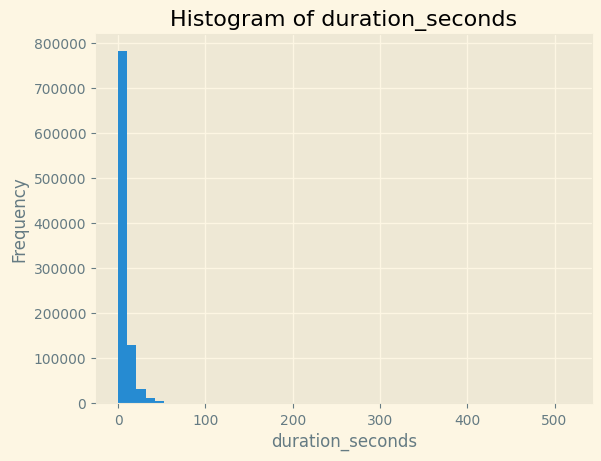

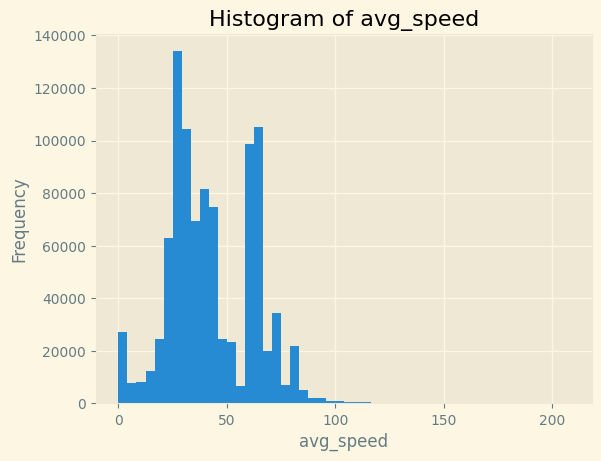

In [22]:
df['duration_seconds'].hist(bins=50)
plt.title('Histogram of duration_seconds')
plt.xlabel('duration_seconds')
plt.ylabel('Frequency')
plt.show()

df['avg_speed'].hist(bins=50)
plt.title('Histogram of avg_speed')
plt.xlabel('avg_speed')
plt.ylabel('Frequency')
plt.show()

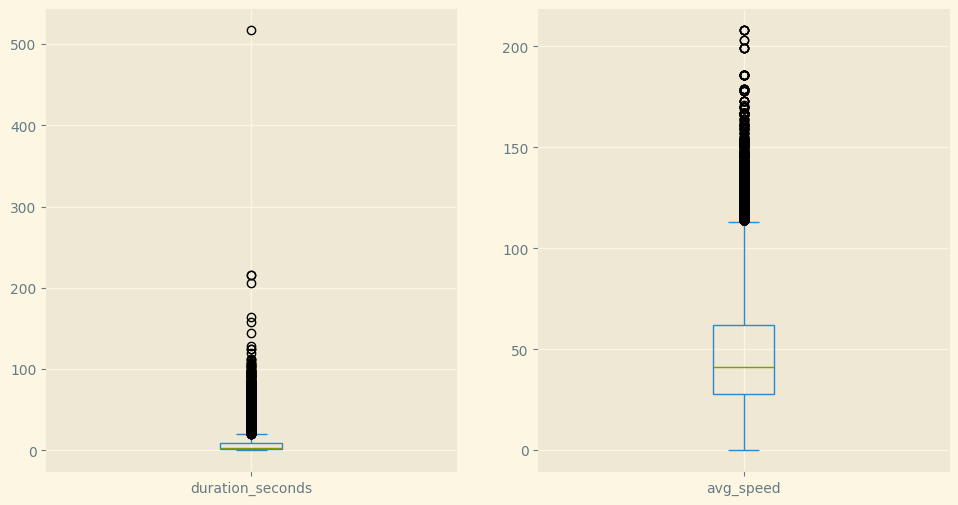

In [23]:
# Box plot for numerical columns
df[['duration_seconds', 'avg_speed']].plot(kind='box', subplots=True, layout=(1, 3), sharey=False, figsize=(18, 6))
plt.show()

In [24]:
# Define the threshold for speeding (e.g., 50 km/h)
speed_threshold = 50

# Mark speeding incidents in the original DataFrame
df['is_speeding'] = df['avg_speed'] > speed_threshold

# Group by road_name and count the number of speeding incidents
speeding_counts = df[df['is_speeding']].groupby('road_name').size().reset_index(name='speeding_count')

# Sort dataframe
speeding_counts = speeding_counts.sort_values(by='speeding_count', ascending=False)

# Display the result
print('Roads with the most instances of speeding:\n', speeding_counts)

Roads with the most instances of speeding:
                   road_name  speeding_count
239     Graaf Engelbertlaan           48806
219  Franklin Rooseveltlaan           33363
483               Moerlaken           27084
684            Tilburgseweg           19807
356             Kapittelweg           19629
..                      ...             ...
671            Tennisstraat               1
308            Hoge Eikberg               1
304          Hoenderparkweg               1
303               Hoeksteen               1
0              't Hofflandt               1

[814 rows x 2 columns]


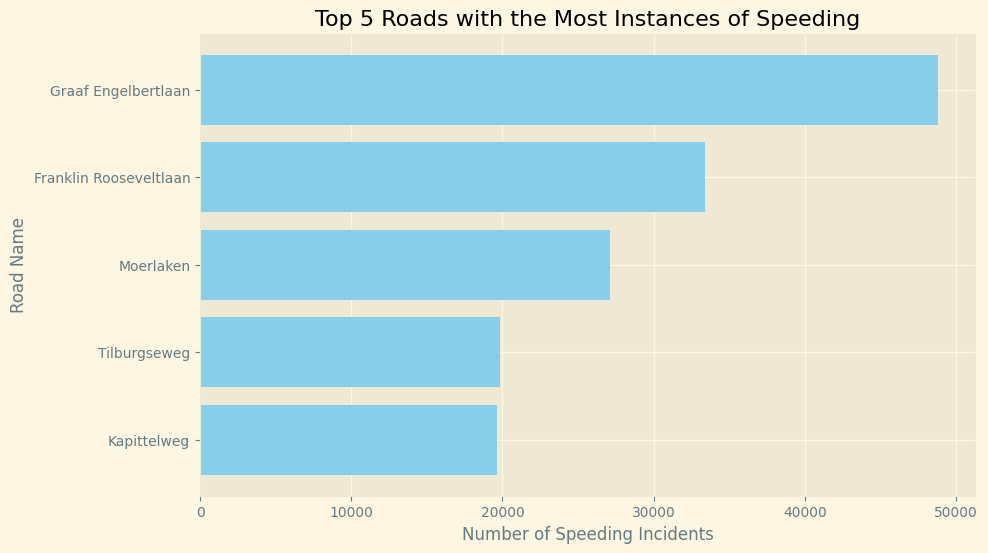

In [25]:
# Filter the top 5 roads
top_5_speeding = speeding_counts.head(5)

# Plot the top 5 roads with the most instances of speeding
plt.figure(figsize=(10, 6))
plt.barh(top_5_speeding['road_name'], top_5_speeding['speeding_count'], color='skyblue')
plt.xlabel('Number of Speeding Incidents')
plt.ylabel('Road Name')
plt.title('Top 5 Roads with the Most Instances of Speeding')
plt.gca().invert_yaxis()  # Invert y-axis to display the road with the highest count at the top
plt.show()

In [26]:
# Calculate the mean of non-zero duration_seconds
mean_duration = df[df['duration_seconds'] > 0]['duration_seconds'].mean()

# Impute the 0 values with the mean duration
df['duration_seconds'] = df['duration_seconds'].replace(0, mean_duration)

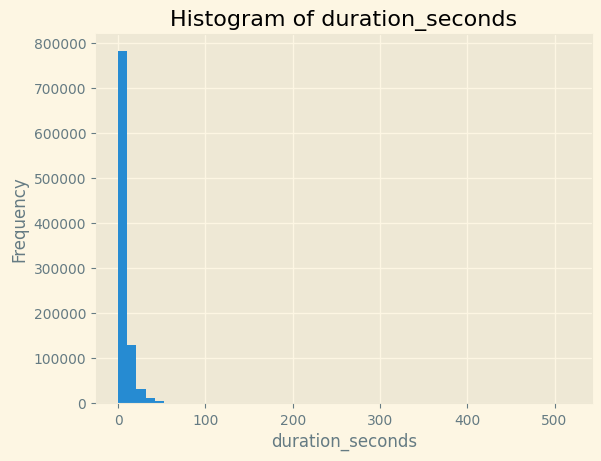

In [27]:
df['duration_seconds'].hist(bins=50)
plt.title('Histogram of duration_seconds')
plt.xlabel('duration_seconds')
plt.ylabel('Frequency')
plt.show()

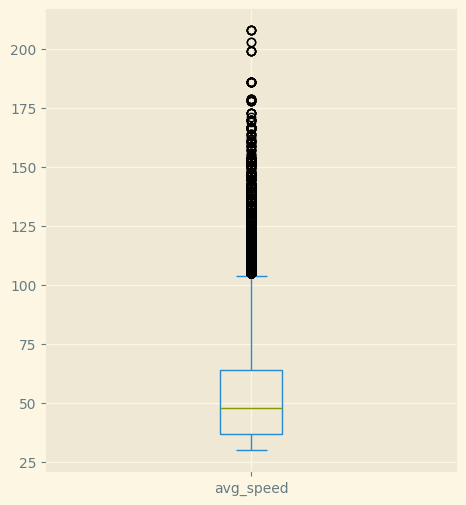

In [28]:
# Remove all instances where the avg_speed < 30kmh
min_speed = 30
df = df[df['avg_speed'] >= min_speed]

# Box plot for numerical columns
df['avg_speed'].plot(kind='box', subplots=True, layout=(1, 3), sharey=False, figsize=(18, 6))
plt.show()

In [29]:
# Remove values considered outliers (over average speed of 200)
df = df[df['avg_speed']<=200]

In [30]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_duration = find_outliers(df, 'duration_seconds')
outliers_avg_speed = find_outliers(df, 'avg_speed')

# Filter outliers where duration_seconds > 60
outliers_duration_filtered = outliers_duration[outliers_duration['duration_seconds'] > 100]

print("Outliers in duration_seconds:\n", outliers_duration_filtered)
print("Outliers in avg_speed:\n", outliers_avg_speed)

Outliers in duration_seconds:
               eventid  duration_seconds  maxwaarde category incident_severity  \
date                                                                            
2024-01-01  129263691             125.0        101    SPEED               SP1   
2023-08-26  122311627             120.0        101    SPEED               SP1   
2023-08-03  121153499             106.0         76    SPEED               SP1   
2023-04-18  112984976             206.0         41    SPEED               SP1   
2023-04-13  113014971             104.0         99    SPEED               SP1   
2023-03-20  111490122             517.0         51    SPEED               SP1   
2023-03-03  112147978             113.0        104    SPEED               SP1   
2023-02-02  108862283             215.6         59    SPEED               SP1   
2023-02-02  108862285             215.6         59    SPEED               SP2   
2022-09-29  101107630             102.0         86    SPEED               SP1 

In [31]:
# Mark outliers in the original DataFrame
df['is_outlier_duration'] = df['duration_seconds'].isin(outliers_duration_filtered['duration_seconds'])

# Group by road_name and count the number of outliers
outlier_counts = df[df['is_outlier_duration']].groupby('road_name')['duration_seconds'].agg(['size', 'mean']).reset_index()
outlier_counts.columns = ['road_name', 'outlier_count_duration', 'mean_duration_seconds']

# Sort dataframe
outlier_counts = outlier_counts.sort_values(by='outlier_count_duration', ascending=False)

# Display the result
print('Roads with the highest duration of incidents:\n', outlier_counts)

Roads with the highest duration of incidents:
                  road_name  outlier_count_duration  mean_duration_seconds
3   Franklin Rooseveltlaan                       4                132.775
4      Graaf Engelbertlaan                       4                108.000
1                  Bijster                       2                215.600
11           Rijsbergseweg                       2                108.000
0              Bavelselaan                       1                206.000
2             Emerparklaan                       1                104.000
5                 Heerbaan                       1                106.100
6   Johan Willem Frisolaan                       1                125.000
7             Kloosterlaan                       1                105.000
8                  Markweg                       1                107.000
9          Oosterhoutseweg                       1                113.000
10              Overaseweg                       1               

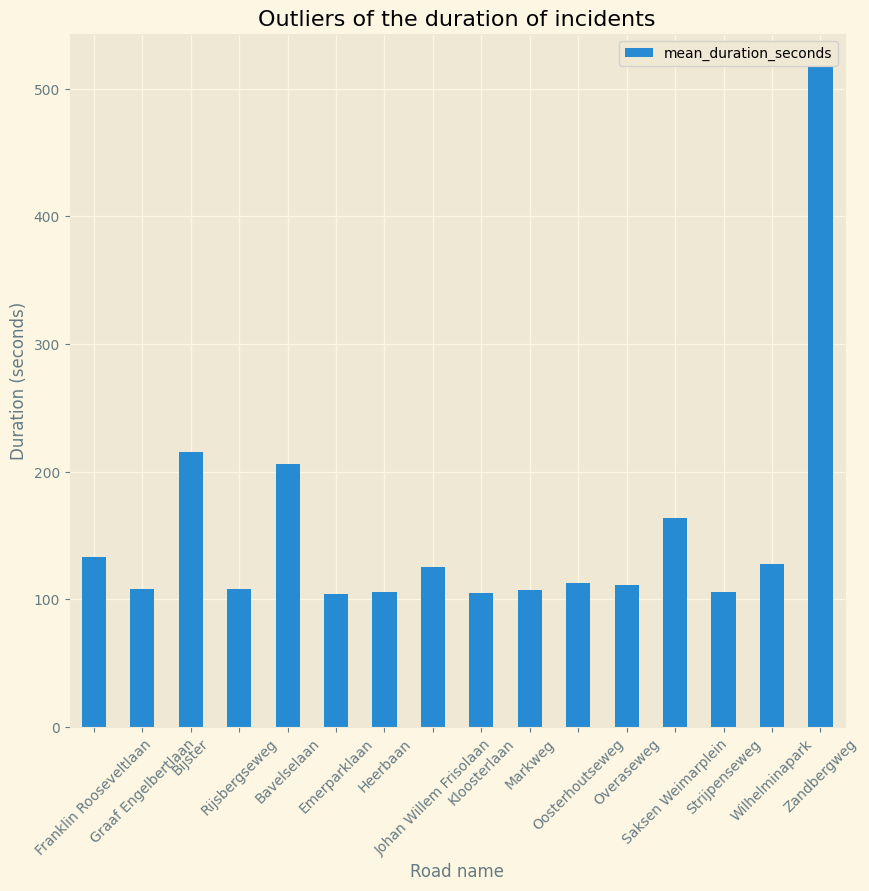

In [32]:
outlier_counts.plot(kind='bar', x= 'road_name', y='mean_duration_seconds', figsize=(10,9))
plt.xticks(rotation=45)
plt.xlabel('Road name')
plt.ylabel('Duration (seconds)')
plt.title('Outliers of the duration of incidents')
plt.show()

### More EDA

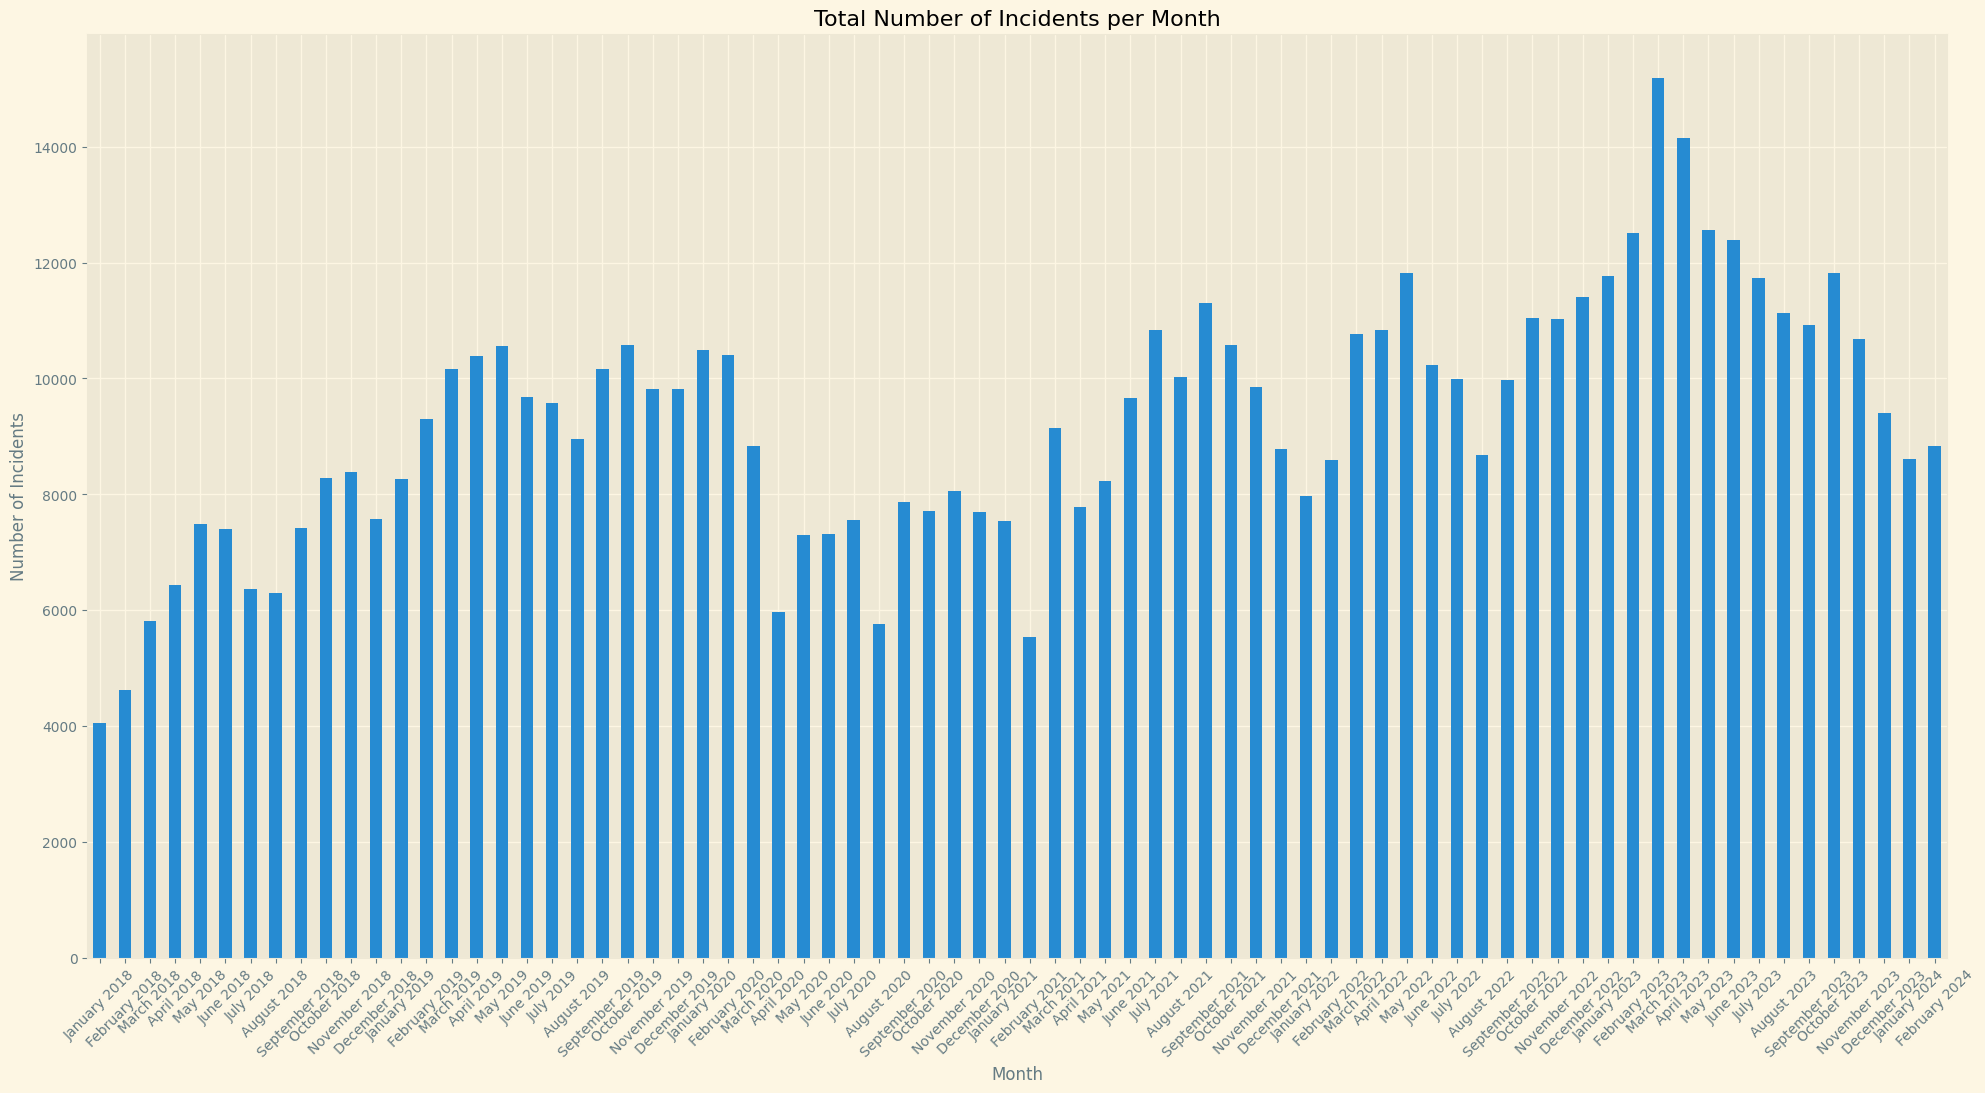

In [33]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Group by month and count the number of incidents in each month
incidents_per_month = df.resample('ME').size()

# Extract month from the index
incidents_per_month.index = incidents_per_month.index.strftime('%B %Y')

# Plot the result
incidents_per_month.plot(kind='bar', figsize=(24, 12))
plt.title('Total Number of Incidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

### Normalization of the data

In [34]:
scaler = RobustScaler()
df[['avg_speed']] = scaler.fit_transform(df[['avg_speed']])

print(df['avg_speed'])

date
2024-02-29   -0.259259
2024-02-29    0.481481
2024-02-29   -0.185185
2024-02-29   -0.148148
2024-02-29   -0.407407
                ...   
2018-01-01    0.518519
2018-01-01   -0.592593
2018-01-01   -0.629630
2018-01-01    0.555556
2018-01-01    0.962963
Name: avg_speed, Length: 685604, dtype: float64


In [35]:
# Select numerical columns
numerical_columns = ['duration_seconds', 'maxwaarde']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [36]:
# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['category', 'place_name'])
print(df)

              eventid  duration_seconds  maxwaarde incident_severity  \
date                                                                   
2024-02-29  132269553         -0.151029   0.063203               SP1   
2024-02-29  132265079          1.039345   0.770775               SP1   
2024-02-29  132285653         -0.151029   0.151650               SP1   
2024-02-29  132318095         -0.924772  -1.145564               HA1   
2024-02-29  132262493         -0.805734  -1.145564               HC1   
...               ...               ...        ...               ...   
2018-01-01    5879594         -0.270066   0.741293               SP1   
2018-01-01    5965670         -0.805734  -1.145564               HC1   
2018-01-01    5408938         -0.722408  -1.145564               HC1   
2018-01-01    5356711         -0.031992   0.829739               SP1   
2018-01-01    5965664          1.741665   1.154042               SP1   

            road_segment_id road_manager_type road_number  \
da

In [37]:
# Define the mapping of original categories to encoded values
mapping = {'low risk': 0, 'medium risk': 1, 'high risk': 2}

# Create a new column with the encoded values
df['risk_category_encoded'] = df['risk_category'].map(mapping)

# Display the updated DataFrame
print(df[['risk_category', 'risk_category_encoded']])

           risk_category  risk_category_encoded
date                                           
2024-02-29      low risk                      0
2024-02-29      low risk                      0
2024-02-29      low risk                      0
2024-02-29      low risk                      0
2024-02-29      low risk                      0
...                  ...                    ...
2018-01-01      low risk                      0
2018-01-01      low risk                      0
2018-01-01      low risk                      0
2018-01-01      low risk                      0
2018-01-01      low risk                      0

[685604 rows x 2 columns]


In [38]:
print(df)

              eventid  duration_seconds  maxwaarde incident_severity  \
date                                                                   
2024-02-29  132269553         -0.151029   0.063203               SP1   
2024-02-29  132265079          1.039345   0.770775               SP1   
2024-02-29  132285653         -0.151029   0.151650               SP1   
2024-02-29  132318095         -0.924772  -1.145564               HA1   
2024-02-29  132262493         -0.805734  -1.145564               HC1   
...               ...               ...        ...               ...   
2018-01-01    5879594         -0.270066   0.741293               SP1   
2018-01-01    5965670         -0.805734  -1.145564               HC1   
2018-01-01    5408938         -0.722408  -1.145564               HC1   
2018-01-01    5356711         -0.031992   0.829739               SP1   
2018-01-01    5965664          1.741665   1.154042               SP1   

            road_segment_id road_manager_type road_number  \
da

### Turning the DataFrame into an SQL table

In [40]:
# Define the schema where you want to store the table
schema = 'group18_warehouse'
 
# Convert DataFrame to SQL table
df.to_sql('ANWB_data', engine, schema='group18_warehouse', if_exists='replace', index=False)
 
# Close the connection
engine.dispose()